Hello and welcome.

In this tutorial I want to analyze bitcoin market-cap using data that i got from web site using beautifulsoup 
I also predict the price using different methods such as machine leraning and Random Walk.


In [8]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] ='serif'

%matplotlib inline

import cufflinks as cf
import plotly.offline as plyo

plyo.init_notebook_mode(connected=True)

Now, I try to read the data that i just created. As my data is kind of time siries data so i should use parse_dates parameter to change dates to correct format, also i set index_col=0 it means the column with index 0 is my index.

In [2]:
df = pd.read_csv('/Users/rop/python/data_science/block_chain/data.csv', index_col = 0, parse_dates = True)

In [3]:
df.head()

,volume,high,market-cap,close,open,low
dates,,,,,,
2017-06-30,8.602730e+08,2559.25,4.168910e+10,2480.84,2539.24,2478.43
2015-06-30,4.453380e+07,267.87,3.682790e+09,263.07,257.04,255.95
2015-12-30,4.688940e+07,434.39,6.508960e+09,426.62,433.30,422.08
2015-12-31,4.599660e+07,432.92,6.399190e+09,430.57,425.88,418.74
2017-09-29,1.367050e+09,4214.63,6.921920e+10,4163.07,4171.62,4039.29


### What is main metrics?why?

I think market-cap is the most important one even much more than value of shares. I will tell you why!

There's a common misconception that a company's per-share stock price holds as much importance as its market capitalization when it comes to choosing stocks to purchase. This fallacy occurs especially often in the case of new investors. Market cap should be your key consideration when you're evaluating a stock because it tells you the value of a company.

You can easily find a company's market cap by multiplying its per-share price by its total number of outstanding shares. This number gives you the total value of the company or stated another way, what it would cost to buy the whole company on the open market.

An Example
Coming up with a company's market cap and comparing it to other companies involves some simple math as follows:

Stock price: $50
Outstanding shares: 50 million
Market cap: $50 x 50,000,000 = $2.5 billion
Look at this second example:

Stock price: $10
Outstanding shares: 300 million
Market cap: $10 x 300,000,000 = $3 billion
Look at these two companies in this manner for evaluation purposes, since their per-share prices tell you nothing by themselves.



Fist of all lets see the distribution of bitcoin market cap during 4 years.

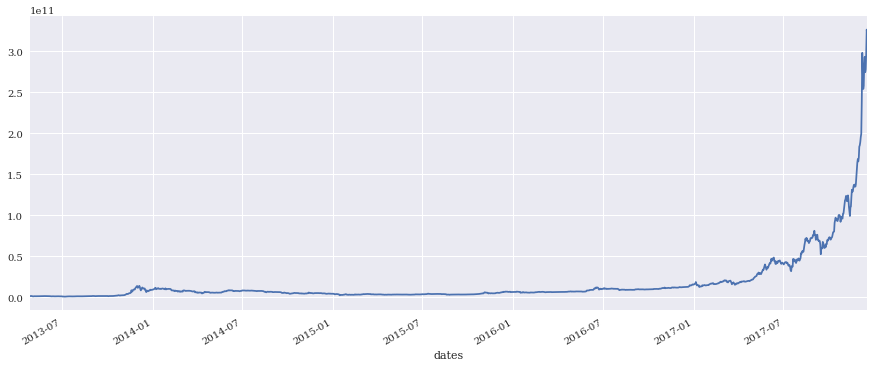

In [7]:
df['market-cap'].plot(figsize = (15,6))

Now Its the time to use important strategy improved types of moving average called weighted moving average wich add more weight to recent values. 

First we need 2 window. We dont now how to choose our window to gain the best result, so i create an optimization function to find bets values for windows. Actually this is kind of brute-force algorithm.

In [17]:
data = df[['market-cap']]


In [28]:
from itertools import product

symbol ='market-cap'
sma1 = range(40,61,4)
sma2 = range(280,281,10)

results = pd.DataFrame()
for SMA1,SMA2 in product(sma1, sma2):
    data = pd.DataFrame(df[symbol])
    data.dropna(inplace = True)
    data['Returns'] = np.log(data[symbol]/data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    
    data.dropna(inplace = True)
    data['Possition'] = np.where(data['SMA1'] > data['SMA2'],1,-1)
    data['Strategy'] = data['Possition'].shift(1) * data['Returns'] 
    data.dropna(inplace = True)
    perf = np.exp(data[['Returns','Strategy']].sum())
    results = results.append(pd.DataFrame({
        'SMA1':SMA1, 'SMA2':SMA2,
        'MARKET':perf['Returns'],
        'Strategy':perf['Strategy'],
        'OUT' : perf['Strategy']- perf['Returns']},
        index = [0]), ignore_index = True)

In [27]:
results.sort_values('OUT',ascending=False).head(10)

,SMA1,SMA2,MARKET,Strategy,OUT
0,50,250,0.057137,3.618581e-26,-0.057137
4,54,250,0.057137,3.598174e-19,-0.057137
8,58,250,0.057137,3.007758e-21,-0.057137
7,54,280,0.521167,7.765843e-16,-0.521167
3,50,280,0.521167,2.429186e-19,-0.521167
11,58,280,0.521167,8.612032e-24,-0.521167
5,54,260,0.527795,1.478471e-10,-0.527795
1,50,260,0.527795,6.150131e-21,-0.527795
9,58,260,0.527795,2.019098e-17,-0.527795
6,54,270,0.926773,5.170075e-15,-0.926773


Well done, As you see, we compute best SMA1 and SMA2 are 50 and 250 respectively.Now we can use this sizes for our windows confidently.

In [41]:
SMA1 = 50
SMA2 = 250

df['ewma_50'] = df['market-cap'].ewm(halflife =0.5, min_periods = 50).mean()
df['ewma_250'] = df['market-cap'].ewm(halflife =0.5, min_periods = 250).mean()

df.dropna(inplace =True)


Here we calculate values for shorter $ewma$ and values for longer $ewma$.

Now that is the strategy:

    1-Go long (= +1) when the shorter ewma is abow the longer ewma.
    2-Go short(= -1) when the shorter ewma is below the lonegr ewma.


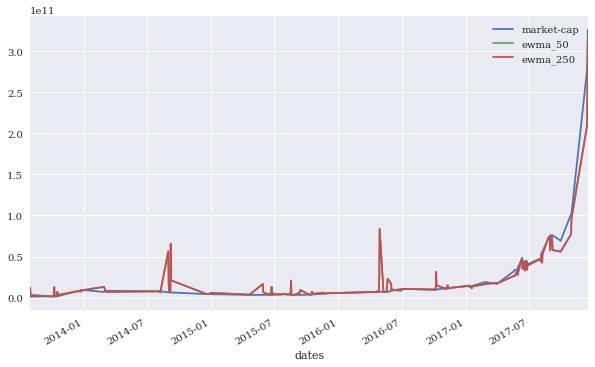

In [45]:
data = df[['market-cap','ewma_50','ewma_250']]
data.plot(figsize = (10,6))

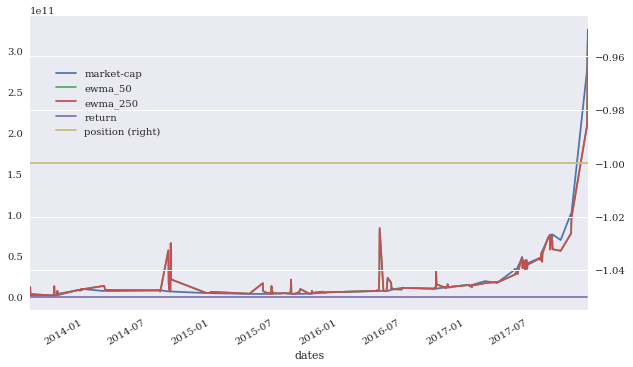

In [52]:
data['position'] = np.where(data['ewma_50'] > data['ewma_250'],1,-1)

ax = data.plot(secondary_y='position', figsize=(10,6))
ax.get_legend().set_bbox_to_anchor((0.25,0.85))

And now i want to create some new useful fetures to help us makes it clear. 
so, I create Return and positions

### Vectorized Back testing

To do vectorized backtesting first we calculate $log-returen$ , then positioning that is -1 or +1, are multiply by the relevant $log-return$ .

In [58]:
data['return'] = np.log(data['market-cap'] / data['market-cap'].shift(1))
data['strategy'] = data['position'].shift(1) * data['return']
data.dropna(inplace= True)
data.head()

np.exp(data[['return','strategy']].sum())

return      0.765214
strategy    1.306824
dtype: float64

It shows that it would not be better for us to hold the stocks for longer time.

lets makes it visual.

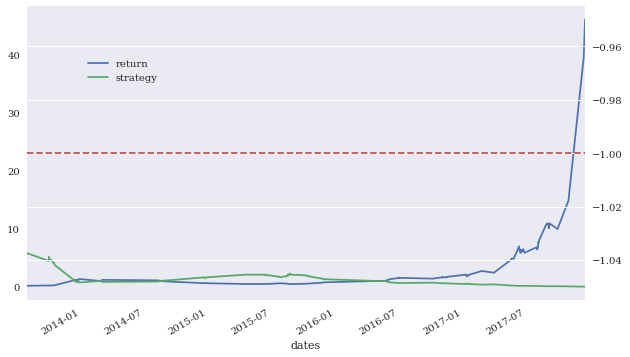

In [59]:
ax = data[['return','strategy']].cumsum().apply(np.exp).plot(figsize =(10,6))
data['position'].plot(ax=ax, secondary_y='position', style ='--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85))

### Prediction & Forcasting

By now we covered some important analysis on data and get return values and some other things. Now i wanna go a step forward and making prediction for future, that might be the goal of finantial analysis.

There is different methods to do this approach but here, i will cover Radnom Walk and Machine learning methods.

#### Random Walk Approach

In [68]:
symbol = 'market-cap'

market_cap = pd.DataFrame(df[symbol])
lags = 5
cols = []

for lag in range(1, lags+1):
    
    col ='lag_{}'.format(lag)
    market_cap[col] =market_cap[symbol].shift(lag)
    cols.append(col)
    

In [69]:
market_cap.head()

,market-cap,lag_1,lag_2,lag_3,lag_4,lag_5
dates,,,,,,
2017-12-15,2.779360e+11,NaN,NaN,NaN,NaN,NaN
2017-12-16,2.973760e+11,2.779360e+11,NaN,NaN,NaN,NaN
2017-12-17,3.261410e+11,2.973760e+11,2.779360e+11,NaN,NaN,NaN
2016-04-29,6.958330e+09,3.261410e+11,2.973760e+11,2.779360e+11,NaN,NaN
2016-04-28,6.889170e+09,6.958330e+09,3.261410e+11,2.973760e+11,2.779360e+11,NaN


In [70]:
market_cap.dropna(inplace = True)

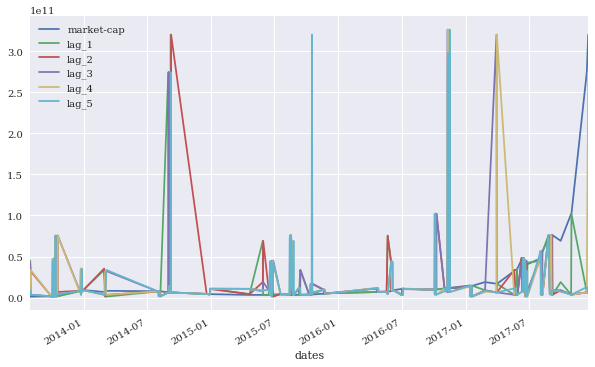

In [75]:
market_cap[['market-cap','lag_1','lag_2','lag_3','lag_4','lag_5']].plot(figsize=(10,6))

So, as we see log_4 is the fittest for predicting the data so we use that for better comparisson in the next plot.

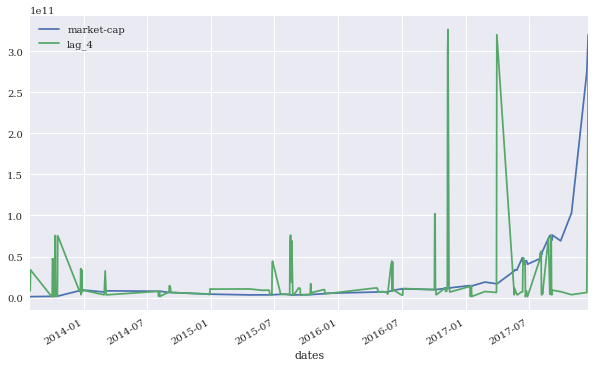

In [88]:
market_cap[['market-cap','lag_4']].plot(figsize=(10,6))

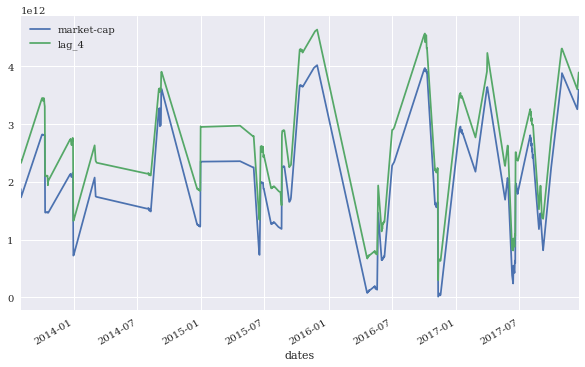

In [106]:
market_cap[['market-cap','lag_4']].cumsum().plot(figsize=(10,6))

#### Machine Learning Approach

The first method that im going to use is the linear regression.

In [95]:
data['direction'] = np.sign(data['return']).astype(int)

In [100]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
data['pos_1'] = model.fit(data[cols],data['return']).predict(data[cols])
data['pos_2'] = model.fit(data[cols],data['direction']).predict(data[cols])

data[['pos_1','pos_2']].head()
data[['pos_1','pos_2']] = np.where(data[['pos_1','pos_2']]>0,1,-1)
data['pos_1'].value_counts()

 1    192
-1     48
Name: pos_1, dtype: int64

In [101]:
data['pos_2'].value_counts()

 1    190
-1     50
Name: pos_2, dtype: int64

In [102]:
data['strat_1'] =data['pos_1'] * data['return']
data['strat_2'] = data['pos_2'] * data['return']

In [103]:
(data['direction'] == data['pos_1']).value_counts()

True     141
False     99
dtype: int64

In [104]:
(data['direction'] == data['pos_2']).value_counts()

True     141
False     99
dtype: int64